In [1]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image

import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

KeyboardInterrupt: 

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
data_dir = r'D:\GH\DeepLearning\dataset\flowers'

In [ ]:
import os

print(os.listdir(data_dir))

image_count = []
for (root, dirs, files) in os.walk(data_dir):
    # print("# root : " + root)
    # if len(dirs) > 0:
    #     for dir_name in dirs:
    #         print("dir: " + dir_name)

    if len(files) > 0:
        for file_name in files:
            # print("file: " + file_name)
            save_file_name = os.path.join(root, file_name)
            image_count.append(save_file_name)

print(len(image_count))
image_count[0]

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
4326


'D:\\GH\\DeepLearning\\dataset\\flowers\\daisy\\100080576_f52e8ee070_n.jpg'

tf.keras.preprocessing 개인 forder로부터 데이터셋 생성
https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
batch_size = 64
img_height = 112
img_width = 112

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


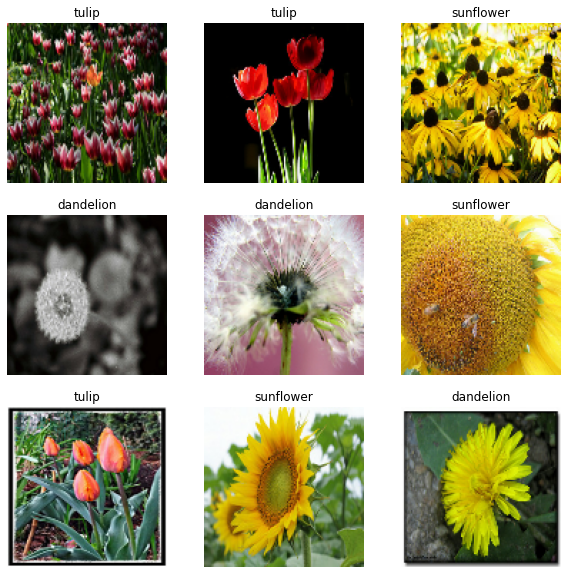

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 112, 112, 3)
(64,)


데이터 표준화

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.03601782 1.0


https://www.tensorflow.org/guide/data_performance#prefetching

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model=Sequential([
    layers.Conv2D(input_shape=(112,112,3),filters=64,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(kernel_size=(3,3),filters=64,strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

    layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
 
    layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

    layers.Flatten(),
    layers.Dense(units=4096,activation='relu'),
    layers.Dense(units=4096,activation='relu'),
    layers.Dense(units=10,activation='softmax')
])

In [ ]:
plot_model(model, to_file='VGGnet_16.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization_8 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_8 (ReLU)              (None, 112, 112, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_9 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_9 (ReLU)              (None, 112, 112, 64)     

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
55/55 [==============================] - 34s 346ms/step - loss: 32.0838 - accuracy: 0.3276 - val_loss: 16.3735 - val_accuracy: 0.2951
Epoch 2/5
55/55 [==============================] - 11s 198ms/step - loss: 1.3261 - accuracy: 0.4354 - val_loss: 3.2580 - val_accuracy: 0.4097
Epoch 3/5
55/55 [==============================] - 11s 200ms/step - loss: 1.2314 - accuracy: 0.4678 - val_loss: 1.4568 - val_accuracy: 0.4317
Epoch 4/5
55/55 [==============================] - 11s 199ms/step - loss: 1.2011 - accuracy: 0.4860 - val_loss: 1.3372 - val_accuracy: 0.4468
Epoch 5/5
55/55 [==============================] - 11s 198ms/step - loss: 1.1690 - accuracy: 0.5074 - val_loss: 1.2705 - val_accuracy: 0.4271


In [ ]:
model.save("models/VGG_based_Flower_001.h5")